In [2]:
# Importar los datos en un dataframe
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
data = pd.read_csv('loan.csv',low_memory=False)
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
data.shape[0]

887379

In [18]:
# Exploración de tipos de variables
data.dtypes.value_counts()

float64    49
object     23
int64       2
dtype: int64

Current                                                      :  601779 (67.82%)
Fully Paid                                                   :  207723 (23.41%)
Charged Off                                                  :   45248 (5.10%)
Late (31-120 days)                                           :   11591 (1.31%)
Issued                                                       :    8460 (0.95%)
In Grace Period                                              :    6253 (0.70%)
Late (16-30 days)                                            :    2357 (0.27%)
Does not meet the credit policy. Status:Fully Paid           :    1988 (0.22%)
Default                                                      :    1219 (0.14%)
Does not meet the credit policy. Status:Charged Off          :     761 (0.09%)


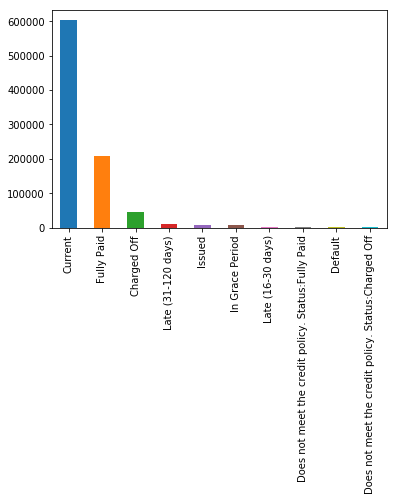

In [56]:
# Explorar las etiquetas de clase
counts_0 = data['loan_status'].value_counts() 
for i in counts_0.index:
    print('{:<60} : {:>7} ({:.2%})'.format(i,counts_0[i],counts_0[i]/data.shape[0]))
data['loan_status'].value_counts().plot(kind='bar')

In [80]:
from datetime import datetime
def to_date(date_str):
    return datetime.strptime(date_str,'%Y%m%d')

# Se crea un dataframe copia de la data con el intervalo de fechas deseado
print('Datos iniciales                       : {:>7}'.format(data.count()[0]))
print(f'-------------------------')
print('Filtrando datos de jul-07 a dic-11')
data['issued'] = pd.to_datetime(data.issue_d)
data2 = pd.DataFrame(data.loc[lambda df: np.logical_and(to_date('20070701') <= df['issued'], df['issued']<=to_date('20111231'))])
print('Datos restantes                       : {:>7}'.format(data2.count()[0]))

# Se filtran los registros inconsistentes o no aplicables para analisis
# Current -> No aplicable porque son préstamos dentro de su periodo de pago.
# Does not meet the credit policy (...) -> Inconsistente. No se sabe si es un error o un valor correcto.
# Issued -> No aplicable porque son créditos recién emitidos.
# In grace period -> No aplicable porque son créditos en periodo de gracia.
print(f'-------------------------')
print('Eliminando registros inconsistentes o no aplicables para analisis.')
estados_eliminar = {'Current','Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off', 'Issued'}
for estado in estados_eliminar:
    data2.drop(data2[data2.loan_status==estado].index,inplace=True)
    #print(f' Eliminado {estado}. Quedan: {data2.count()[0]}')
print('Datos restantes                       : {:>7}'.format(data2.count()[0]))

Datos iniciales                       :  887379
-------------------------
Filtrando datos de jul-07 a dic-11
Datos restantes                       :   42511
-------------------------
Eliminando registros inconsistentes o no aplicables para analisis.
Datos restantes                       :   37825


-------------------------
Se crearon las clases
Valores de la etiqueta de clase:
 Clase 3 (Fully Paid          )                              :   32150 (85.00%)
 Clase 1 (Default|Charged Off )                              :    5583 (14.76%)
 Clase 2 (Late                )                              :      92 (0.24%)


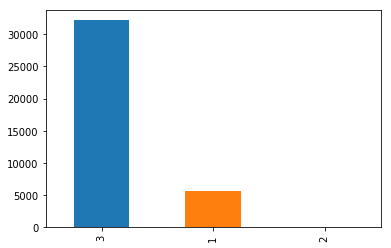

In [102]:
# Se crean las clases
# 1: Default|Charged Off
# 2: Late (31-120 days)|Late (16-30 days)
# 3: Fully Paid
class_dict = ['Default|Charged Off','Late','Fully Paid']
data2['class'] = 3*(data2.loan_status=='Fully Paid') + 2*(np.logical_or(np.logical_or((data2.loan_status=='Late (16-30 days)'),(data2.loan_status=='Late (31-120 days)')),(data2.loan_status=='In Grace Period'))) + 1*(np.logical_or((data2.loan_status=='Default'),(data2.loan_status=='Charged Off')))
print(f'-------------------------')
print('Se crearon las clases')
# Verificacion de los registros resultantes
print('Valores de la etiqueta de clase:')
counts_2 = data2['class'].value_counts()
for i in counts_2.index:
    print(' Clase {} ({:<20})                              : {:>7} ({:.2%})'.format(i,class_dict[i-1],counts_2[i],counts_2[i]/data2.shape[0]))
data2['class'].value_counts().plot(kind='bar')

In [ ]:
# NO EJECUTAR - GENERA EL OUTPUT CON ERROR
# SE GUARDA PARA VERSIONADO

#from datetime import datetime
#def to_date(date_str):
#    return datetime.strptime(date_str,'%Y%m%d')
    
# Se filtran los datos de julio 2007 a diciembre 2011
#print(f'Data original:{data.count()[0]}')
#print('Filtrando datos de jul-07 a dic-11')
#data['issued'] = pd.to_datetime(data.issue_d)
#data2 = data.where(lambda x: x.issued>=to_date('20070701')).where(lambda x: x.issued<=to_date('20111231'))
#print(f'Data de jul-07 a dic-11: {data2.count()[0]}')

# Se filtran los registros inconsistentes o no aplicables para analisis
# Current -> No aplicable porque son préstamos dentro de su periodo de pago.
# Does not meet the credit policy (...) -> Inconsistente. No se sabe si es un error o un valor correcto.
# Issued -> No aplicable porque son créditos recién emitidos.
# In grace period -> No aplicable porque son créditos en periodo de gracia.
#print('Eliminando registros inconsistentes o no aplicables para analisis.')
#estados_eliminar = {'In Grace Period','Current','Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off', 'Issued'}
#for estado in estados_eliminar:
#    data2.drop(data2[data2.loan_status==estado].index,inplace=True)
#    print(f'Eliminado {estado}. Quedan: {data2.count()[0]}')
    
# Se crean las clases
# 1: Default|Charged Off
# 2: Late (31-120 days)|Late (16-30 days)
# 3: Fully Paid
#data2['class'] = 3*(data2.loan_status=='Fully Paid') + 2*((data2.loan_status=='Late (16-30 days)') | (data2.loan_status=='Late (31-120 days)')) + 1*((data2.loan_status=='Default') | (data2.loan_status=='Charged Off'))
#print('Se crearon las clases.')

In [99]:
# Explorar la distribución de la etiqueta de clase
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=FutureWarning)
    #aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum','contador':lambda x: int(sum(x)/data2.loc[x.index].loan_amnt.sum())}}
    aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum'}}
    data_res=data2.groupby(['class','loan_status'],as_index=True).agg(aggregation_function)
data_res['id','porcentaje_cuenta'] = round(data_res['id','cuenta']/data_res['id'].sum()[0]*100,2)
data_res['loan_amnt','porcentaje_monto'] = round(data_res['loan_amnt','suma']/data_res['loan_amnt'].sum()[0]*100,2)
data_res.sort_index(axis=1)

id                          loan_amnt  \
                         cuenta porcentaje_cuenta porcentaje_monto   
class loan_status                                                    
1     Charged Off          5574             14.74            16.19   
      Default                 9              0.02             0.03   
2     In Grace Period        28              0.07             0.11   
      Late (16-30 days)      13              0.03             0.05   
      Late (31-120 days)     51              0.13             0.22   
3     Fully Paid          32150             85.00            83.41   

                                       
                                 suma  
class loan_status                      
1     Charged Off          67205600.0  
      Default                122000.0  
2     In Grace Period        448700.0  
      Late (16-30 days)      197600.0  
      Late (31-120 days)     903125.0  
3     Fully Paid          346213675.0

In [ ]:
# Balanceo tomando 7000 registros de tipo Fully Paid y explorar el resultado final
n_rows_to_delete = data2[data2['class']==3].count()[0]-7000
data3 = data2.drop(data2[data2['class']==3].sample(n=n_rows_to_delete,random_state=40).index)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=FutureWarning)
    aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum'}}
    data_show=data3.groupby(['class','loan_status'],as_index=True).agg(aggregation_function)
data_show['id','porcentaje_cuenta'] = round(data_show['id','cuenta']/data_show['id'].sum()[0]*100,2)
data_show['loan_amnt','porcentaje_monto'] = round(data_show['loan_amnt','suma']/data_show['loan_amnt'].sum()[0]*100,2)
data_show.sort_index(axis=1)

In [ ]:
# Explorar el proposito de las deudas
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=FutureWarning)
    aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum'}}
    data_show=data3.groupby('purpose',as_index=True).agg(aggregation_function)
data_show['id','porcentaje_cuenta'] = round(data_show['id','cuenta']/data_show['id'].sum()[0]*100,2)
data_show['loan_amnt','porcentaje_monto'] = round(data_show['loan_amnt','suma']/data_show['loan_amnt'].sum()[0]*100,2)
data_show.sort_index(axis=1).sort_values(by=[('id','porcentaje_cuenta')],ascending=False)

In [ ]:
# Explorar los datos categóricos (no numéricos)
data3[data3.select_dtypes(include='object').columns.tolist()].head(3)

In [ ]:
# Del resultado anterior, se observa que se puede procesar emp_length para que sea numerico
import re

# Se crea una columna auxiliar para el procesamiento. Se extrae usando expresiones regulares, se convierte a entero 
# y finalmente se elimina la columna auxiliar
data3['emp_length_str'] = data3['emp_length'].astype(str)
data3['emp_length_prc'] = data3['emp_length_str'].apply(lambda x: re.findall('\d+',x)[0] if re.findall('\d+',x)!=[] else 0)
data3['emp_length_prc'] = data3['emp_length_prc'].astype(int)
data3.drop(columns='emp_length_str',inplace=True)
data3.head(3)

In [ ]:
# Tambien se observa que se puede procesar manualmente la columna term_str para que sea numerica
import re

# Se crea una columna auxiliar para el procesamiento. Se extrae usando expresiones regulares, se convierte a entero 
# y finalmente se elimina la columna auxiliar
data3['term_str'] = data3['term'].astype(str)
data3['term_prc'] = data3['term_str'].apply(lambda x: re.findall('\d+',x)[0] if re.findall('\d+',x)!=[] else 0)
data3['term_prc'] = data3['term_prc'].astype(int)
data3.drop(columns='term_str',inplace=True)
data3.head()

In [ ]:
# Eliminar columnas de id
id_lst=list(map(lambda x: 'id' in x,data3.columns))
id_column_name_lst = list(data3.columns[id_lst])
print(f'Numero de columnas original: {len(data3.columns.tolist())}')
data_clear = data3.drop(columns=id_column_name_lst, axis=1)
print(f'Numero de columnas filtrado: {len(data_clear.columns.tolist())}')

# Eliminar manualmente columnas de fechas, los campos originales que fueron procesados manualmente 
# y otras que carecen de relevancia
columnas_eliminar = ['url','earliest_cr_line','zip_code','last_credit_pull_d',
                     'issue_d','last_pymnt_d','next_pymnt_d','issued','term','emp_length','loan_status']
data_clear.drop(columns=columnas_eliminar,inplace=True)

# Codificar campos categóricos
print(f'Codificando campos categoricos')
cat_cols = data_clear.select_dtypes(include='object').columns.tolist()
cat_dict = dict()
for col in cat_cols:
    data_clear[col] = data_clear[col].astype('category')
    cat_dict[col] = {i+1:c for i,c in enumerate(data_clear[col].cat.categories)}
    data_clear[col] = data_clear[col].cat.codes+1
print('Campos categoricos codificados.')

In [ ]:
# Se eliminan las columnas con mas de 100% de sus valores perdidos (nulos)
print('Eliminando columnas con mas de 100% de valores perdidos...')
print(f'Cantidad de columnas originales: {data_clear.shape[1]}')
cols_elim = [x for x in data_clear.columns if ((x!='mths_since_last_delinq') & (data_clear[x].isnull().sum()==data_clear.count().max()))]
print(f'Cantidad de columnas a eliminar: {len(cols_elim)}')
data_clear.drop(columns=cols_elim,axis=1,inplace=True)
print(f'Cantidad de columnas finales: {data_clear.shape[1]}')

In [ ]:
# https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d
# Llenar valores vacios con media
from sklearn.preprocessing import Imputer 
imp = Imputer(missing_values='NaN',strategy='median',axis=0,verbose=10)
imp.fit(data_clear)
data_clear_f = imp.transform(data_clear)
print(f'Llenando los vacios con el valor de la mediana.')
# data_clear_f = data_clear.fillna(value=data_clear.median())

In [ ]:
data_clear_f2 = pd.DataFrame(data=data_clear_f,columns=data_clear.columns)
print(f'Presencia de nulos: {np.any(data_clear_f2.isnull())}')
data_clear_f2.head()

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = data_clear_f2[data_clear_f2.drop(columns='class',axis=1).columns.tolist()]
y = data_clear_f2['class']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, random_state=40)
print(f'El set de entrenamiento/validacion tiene {len(X_trainval)} muestras.')
print(f'El set de pruebas tiene {len(X_test)} muestras.')

In [ ]:
# Fuente: documentacion Scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(X_trainval):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    #CART = tree.DecisionTreeClassifier(criterion='entropy',splitter='random',max_depth=10,min_samples_leaf=3,max_features=10)
    #CART = CART.fit(X_train,y_train)
    RF = RandomForestClassifier(n_estimators=10,max_depth=5,bootstrap=False,max_features=15)
    RF = RF.fit(X_train,y_train)
    classifiers_lst.append(RF)
    y_pred = RF.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    scores_lst.append(score)
# avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
# best_class = sorted(zip(scores_lst,classifiers_lst),key=f_first,reverse=True)[0]
best_class = sorted(zip(scores_lst,classifiers_lst),key=(lambda x:x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class[1].predict(X_test)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

In [ ]:
# Se recuperan los 15 features más importantes
# feature_vector_importance =[list(x) for x in sorted(zip(X_trainval.columns,best_class[1].feature_importances_),key=(lambda x:x[1]),reverse=True)][0:15]
feature_vector_importance = pd.DataFrame({'feature':X_trainval.columns.tolist(),
                                          'importance':best_class[1].feature_importances_.tolist()})
feature_vector_importance.sort_values(by='importance',kind='quicksort',ascending=False).reset_index(drop=True)['feature'][0:25]

In [ ]:
# Ayuda de: https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas
# https://datascience.stackexchange.com/questions/17540/make-seaborn-heatmap-bigger

# Se analiza la correlación entre los elementos del vector de características
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplots(figsize=(20,15))
corr = data_clear_f2.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Se compara lo obtenido por random forest vs el analisis de correlación para descartar variables:

collection_recovery_fee - x (Correlacion con recoveries) y tampoco tiene sentido para predecir si el cliente es nuevo
total_rec_prncp - x No tiene sentido para predecir si el cliente es nuevo
recoveries - x No tiene sentido para predecir si el cliente es nuevo
loan_amnt - 1
total_pymnt_inv - x No tiene sentido para predecir si el cliente es nuevo
installment - x (Correlacion con loan_amnt)
out_prncp - 2
last_pymnt_amnt - x No tiene sentido para predecir si el cliente es nuevo
term_prc (term) - 3
total_rec_int - x No tiene sentido para predecir si el cliente es nuevo
subgrade - 4
total_rec_late_fee - x No tiene sentido para predecir si el cliente es nuevo
revol_util - 5
annual_inc - 6
revol_bal - 7
int_rate - 8
dti - 9
desc - x No tiene sentido, es un campo de descripcion
title - 10 

Del analisis anterior se ve que hay demasiadas columnas que por reglas de negocio no deberían usarse para tratar de predecir un crédito. Se revisó el diccionario de datos y se eliminaron más columnas.

In [ ]:
data_clear_f3.columns

In [ ]:
columnas_eliminar = {'desc', # desc es la descripcion del credito, puede tener cualquier valor
                     # Información de pagos no puede usarse para predecir un crédito
                     'total_pymnt', 
                     'total_pymnt_inv', 
                     'last_pymnt_amnt',
                     # Información de recuperación de inversión no puede usarse para predecir un crédito
                     'recoveries',  
                     'collection_recovery_fee',
                     'total_rec_prncp',
                     'total_rec_int',
                     'total_rec_late_fee',
                     # Información de saldo deudor no puede usarse para predicción de créditos
                     'out_prncp_inv',
                     'out_prncp',
                     # Información de nomenclaturas no tiene sentido en una predicción de préstamo
                     'title', # Nombre del préstamo asignado por el prestatario
                     'emp_title',# Nombre del trabajo asignado por el prestatario
                     'funded_amnt_inv', # Total de inversion de prestamistas hasta dicho momento en el tiempo. 
                                       # No tiene sentido su inclusión porque si se quiere predecir un nuevo préstamo
                                       # todavía no hay inversión alguna
                     'addr_state' # información geográfica no es un criterio financiero para evaluar a un solicitante
                     }
data_clear_f3 = data_clear_f2.drop(columns=columnas_eliminar)

X2 = data_clear_f3[data_clear_f3.drop(columns='class',axis=1).columns.tolist()]
y2 = data_clear_f3['class']

X_trainval, X_test, y_trainval, y_test = train_test_split(X2, y2, test_size=0.20, random_state=40)
print(f'El set de entrenamiento/validacion tiene {len(X_trainval)} muestras.')
print(f'El set de pruebas tiene {len(X_test)} muestras.')

In [ ]:
# Fuente: documentacion Scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(X_trainval):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    #CART = tree.DecisionTreeClassifier(criterion='entropy',splitter='random',max_depth=10,min_samples_leaf=3,max_features=10)
    #CART = CART.fit(X_train,y_train)
    RF = RandomForestClassifier(n_estimators=10,max_depth=5,bootstrap=False,max_features=15)
    RF = RF.fit(X_train,y_train)
    classifiers_lst.append(RF)
    y_pred = RF.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    scores_lst.append(score)
# avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
# best_class = sorted(zip(scores_lst,classifiers_lst),key=f_first,reverse=True)[0]
best_class = sorted(zip(scores_lst,classifiers_lst),key=(lambda x:x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class[1].predict(X_test)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

In [ ]:
# Se recuperan los 15 features más importantes
# feature_vector_importance =[list(x) for x in sorted(zip(X_trainval.columns,best_class[1].feature_importances_),key=(lambda x:x[1]),reverse=True)][0:15]
feature_vector_importance_2 = pd.DataFrame({'feature':X_trainval.columns.tolist(),
                                          'importance':best_class[1].feature_importances_.tolist()})
feature_vector_importance_2.sort_values(by='importance',kind='quicksort',ascending=False).reset_index(drop=True)['feature'][0:25]

In [ ]:
# Ayuda de: https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas
# https://datascience.stackexchange.com/questions/17540/make-seaborn-heatmap-bigger

# Se analiza la correlación entre los elementos del vector de características
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplots(figsize=(20,15))
corr = data_clear_f3.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

term_prc - 1
int_rate - 2
subgrade y grade - Correlacionados, permanece Grade - 3
annual_inc - 4
purpose - 5
revol_util - 6 
revol_bal - 7
dti - 8
total_acc - 9
installment - 10

In [ ]:
selected_columns = ['term_prc','loan_amnt','revol_util','grade','annual_inc','purpose','pymnt_plan','revol_bal','dti','mths_since_last_delinq']
data_set_paper = X_trainval[selected_columns] 
data_set_paper_test = X_test[selected_columns]

In [ ]:
# Fuente: documentacion Scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(data_set_paper):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = data_set_paper.iloc[train_index], data_set_paper.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    CART = tree.DecisionTreeClassifier(criterion='entropy',splitter='random',max_depth=7, min_samples_leaf=1)
    CART = CART.fit(X_train,y_train)
    classifiers_lst.append(CART)
    y_pred = CART.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    scores_lst.append(score)
#avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
best_class_tree = sorted(zip(scores_lst,classifiers_lst),key=(lambda x: x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class_tree)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class_tree[1].predict(data_set_paper_test)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_set_paper)
data_set_paper_scl = pd.DataFrame(data=scaler.transform(data_set_paper),columns=data_set_paper.columns) 

# Aplicar el mismo escalamiento al set de pruebas
# scaler.fit(data_set_paper_test)
data_set_paper_test_scl = pd.DataFrame(data=scaler.transform(data_set_paper_test),columns=data_set_paper_test.columns)  

In [ ]:
# Multi-layer perceptron (MLP)
# http://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(data_set_paper_scl):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = data_set_paper_scl.iloc[train_index], data_set_paper_scl.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    print("Entrenando clasificador...")
    MLP = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(7), random_state=1)
    MLP = MLP.fit(X_train,y_train)
    classifiers_lst.append(MLP)
    y_pred = MLP.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    print(f'Score: {score}')
    scores_lst.append(score)
#avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
best_class_mlp = sorted(zip(scores_lst,classifiers_lst),key=(lambda x: x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class_mlp)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class_mlp[1].predict(data_set_paper_test_scl)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(data_set_paper_scl):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = data_set_paper_scl.iloc[train_index], data_set_paper_scl.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    print("Entrenando clasificador...")
    SVC_model = SVC(C=1,kernel='rbf')
    SVC_model = SVC_model.fit(X_train,y_train)
    classifiers_lst.append(SVC_model)
    y_pred = SVC_model.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    print(f'Score: {score}')
    scores_lst.append(score)
#avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
best_class_svc = sorted(zip(scores_lst,classifiers_lst),key=(lambda x: x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class_svc)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class_svc[1].predict(data_set_paper_test_scl)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')